## 팀타율 / 팀방어율 arima 예측

In [23]:
import pandas as pd
import numpy as np
import os

import warnings
import itertools as it # 반복 가능한 데이터 스트림을 처리하는 데 유용한 많은 함수와 제네레이터가 포함
warnings.filterwarnings("ignore")
import statsmodels.api as sm #통계분석 기능을 제공하는 파이썬 패키지
from statsmodels.tsa.arima_model import ARIMA
import datetime
from tqdm import tqdm
os.chdir("D:\\DATA\\bigcon")

## visualize
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from matplotlib import style
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')

#### 팀타율

In [24]:
ttasa = pd.read_csv("ttasa.csv",index_col=0,encoding =' cp949')

In [25]:
ttasa.head()

,게임키,일자,팀코드,상대팀코드,더블헤더코드,초말,타자,타수,타점,득점,...,4구,고4,사구,삼진,병살타,실책,잔루,득점권타율,득점권타수,득점권안타
0,20160401HHLG0,20160401,LG,HH,0,B,47,42,4,5,...,4,0,0,11,0,0,8,0.333333,12,4
1,20160401HHLG0,20160401,HH,LG,0,T,52,46,4,4,...,3,0,0,10,1,2,12,0.200000,15,3
2,20160401HTNC0,20160401,NC,HT,0,B,36,30,5,5,...,5,0,0,9,1,1,7,0.142857,7,1
3,20160401HTNC0,20160401,HT,NC,0,T,38,34,3,4,...,3,0,1,10,1,0,7,0.100000,10,1
4,20160401KTSK0,20160401,SK,KT,0,B,36,36,4,4,...,0,0,0,7,1,1,5,0.375000,8,3


In [26]:
#누적 구하기
def calm_basic(df,cols):    
  df['년도'] = df.일자.apply(lambda x: x.year)
  df16,df17,df18,df19,df20 = [df[df. 년도==i] for i in [2016,2017,2018,2019,2020]]
  for col in cols:
    df16[col] = list(it.accumulate(df16[col]))
    df17[col] = list(it.accumulate(df17[col]))
    df18[col] = list(it.accumulate(df18[col]))
    df19[col] = list(it.accumulate(df19[col]))
    df20[col] = list(it.accumulate(df20[col]))
  d = pd.concat([df16,df17,df18,df19,df20],axis=0)
  return d  

In [87]:
ttasa.일자 = pd.to_datetime(ttasa.일자, format='%Y%m%d')
ta = ttasa.loc[:,['팀코드','일자','안타','타수']]

for i in ta.팀코드.unique().tolist():
    globals()['ta{}'.format(i)] = ta[(ta.팀코드 == i)].reset_index(drop=True)  
    globals()['ta{}'.format(i)] = calm_basic(globals()['ta{}'.format(i)],cols = ['안타','타수'])
    globals()['ta{}'.format(i)]['타율'] = globals()['ta{}'.format(i)].안타 / globals()['ta{}'.format(i)].타수  
    #2019 + 2020
    globals()['ta{}'.format(i)] = globals()['ta{}'.format(i)][(globals()['ta{}'.format(i)].일자.dt.year==2020) | (globals()['ta{}'.format(i)].일자.dt.year==2019)] 
    

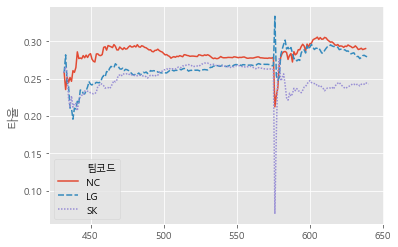

In [88]:
import seaborn as sns
sns.lineplot(x=pd.concat([taNC,taLG,taSK],axis=0).index, y = '타율',hue = '팀코드' ,data = pd.concat([taNC,taLG,taSK],axis=0),style="팀코드")

#### 팀방어율

In [76]:
ttusu = pd.read_csv("ttusu.csv",index_col=0,encoding =' cp949')

In [89]:
ttusu.일자 = pd.to_datetime(ttusu.일자, format='%Y%m%d')
tu = ttusu.loc[:,['팀코드','일자','이닝*3','자책점']]

for i in tu.팀코드.unique().tolist():
    globals()['tu{}'.format(i)] = tu[(tu.팀코드 == i)].reset_index(drop=True)
    globals()['tu{}'.format(i)]['이닝'] = globals()['tu{}'.format(i)]['이닝*3'] / 3
    globals()['tu{}'.format(i)] = calm_basic(globals()['tu{}'.format(i)],cols = ['자책점','이닝'])
    globals()['tu{}'.format(i)]['방어율'] = globals()['tu{}'.format(i)].자책점 * 9 / globals()['tu{}'.format(i)].이닝
    #2019 + 2020
    globals()['tu{}'.format(i)] = globals()['tu{}'.format(i)][(globals()['tu{}'.format(i)].일자.dt.year==2020) | (globals()['tu{}'.format(i)].일자.dt.year==2019)] 
    

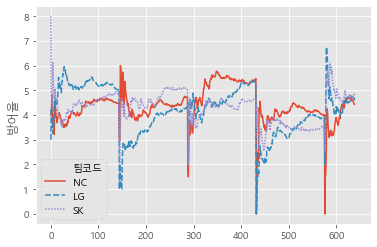

In [78]:
import seaborn as sns
sns.lineplot(x=pd.concat([tuNC,tuLG,tuSK],axis=0).index, y = '방어율',hue = '팀코드' ,data = pd.concat([tuNC,tuLG,tuSK],axis=0),style="팀코드")

#### ex) 팀별 훈련 및 평가(한달)

In [91]:
# 한 경기를 하루하루 보기위해 임의적인 날짜를 설정
#타율 : ['taNC','taLG', 'taWO', 'taSS','taHT', 'taKT', 'taLT', 'taOB', 'taHH','taSK']
#방어율 : ['tuNC','tuLG', 'tuWO', 'tuSS','tuHT', 'tuKT', 'tuLT', 'tuOB', 'tuHH','tuSK']
for i in ['tuNC','tuLG', 'tuWO', 'tuSS','tuHT', 'tuKT', 'tuLT', 'tuOB', 'tuHH','tuSK']:
    globals()['{}'.format(i)].index = pd.date_range(start="2019-1-1", periods=len(globals()['{}'.format(i)]))
    series = globals()['{}'.format(i)].방어율 #타율/방어율

    #2020년 8월까지 훈련 / 9월 한달 예측 후 평가
    real = series[-31:]
    series = series[:-31]

    #arima의 모수는 p,d,q : 각 범위 0~2로 하여 모든 경우의 aic를 뽑은 후 제일 작은 값의 모수를 사용
    p = d = q = range(0, 3)
    pdq = list(it.product(p, d, q))

    m_param = []
    m_aic = []

    for param in pdq:
        try:
            model = ARIMA(series, order=param)
            model_fit = model.fit(trend='c',full_output=True, disp=1)
            #print('ARIMA{} - AIC:{}'.format(param, model_fit.aic))
            m_aic.append(model_fit.aic)
            m_param.append(param)
        except:
            pass
    m_param = m_param[np.argmin(m_aic)]
    print(m_param)
    model = ARIMA(series, order=m_param)        
    model_fit = model.fit(trend='c',full_output=True, disp=1)
    #print(model_fit.summary())
    fore = model_fit.forecast(steps=31)

    mse = ((real - fore[0])**2).sum() / 31
    rmse = mse **0.5
    print(i[-2:]," :", rmse)

(1, 0, 0)
NC  : 0.7722761404631152
(2, 1, 2)
LG  : 0.29036913733778397
(1, 0, 2)
WO  : 0.3104722068160663
(2, 1, 2)
SS  : 0.2666093457949043
(1, 0, 2)
HT  : 0.643579375092559
(2, 1, 2)
KT  : 0.2733327922192883
(1, 1, 2)
LT  : 0.2720700955676049
(2, 1, 2)
OB  : 0.30545910707858087
(2, 1, 2)
HH  : 0.826056666828777
(2, 0, 2)
SK  : 0.5808575390016109


## 모든 팀 ARIMA 예측 함수
남은 경기
hh 73
ht 72
kt 72
lg 75
lt 72
nc 72
ob 73
sk 73
ss 72
wo 76

In [63]:
def arima_basic(df,kind):
    df.index =  pd.date_range(start="2019-1-1", periods=len(df))
    if kind == 'tasa':    
        series = df.타율
    else :
        series = df.방어율
    
    #arima의 모수는 p,d,q : 각 범위 0~2로 하여 모든 경우의 aic를 뽑은 후 제일 작은 값의 모수를 사용

    p = d = q = range(0, 3)
    pdq = list(it.product(p, d, q))

    m_param = []
    m_aic = []

    for param in pdq:
        try:
            model = ARIMA(series, order=param)
            model_fit = model.fit(trend='c',full_output=True, disp=1)
            #print('ARIMA{} - AIC:{}'.format(param, model_fit.aic))
            m_aic.append(model_fit.aic)
            m_param.append(param)
        except:
            pass
    m_param = m_param[np.argmin(m_aic)]
    print(m_param)
    model = ARIMA(series, order=m_param)        
    model_fit = model.fit(trend='c',full_output=True, disp=1)
    fore = model_fit.forecast(steps=76)
    
    return fore[0]

In [93]:
for i in ['dfNC','dfLG', 'dfWO', 'dfSS','dfHT', 'dfKT', 'dfLT', 'dfOB', 'dfHH','dfSK']:
    globals()['tasa_{}'.format(i[-2:])] = arima_basic(globals()['ta{}'.format(i[-2:])],"tasa")

for i in ['dfNC','dfLG', 'dfWO', 'dfSS','dfHT', 'dfKT', 'dfLT', 'dfOB', 'dfHH','dfSK']:
    globals()['tusu_{}'.format(i[-2:])] = arima_basic(globals()['tu{}'.format(i[-2:])],"tusu")    

(2, 0, 1)
(2, 1, 2)
(2, 0, 2)
(1, 0, 0)
(2, 1, 2)
(2, 0, 2)
(1, 0, 0)
(2, 1, 0)
(2, 1, 1)
(1, 0, 2)
(1, 1, 1)
(2, 1, 2)
(1, 0, 2)
(2, 1, 2)
(1, 0, 2)
(2, 1, 2)
(1, 1, 2)
(2, 1, 2)
(2, 1, 2)
(2, 1, 1)


In [111]:
tusu_LG[52]

5.8682750733720015

In [12]:
remain = {"HH" :73, "HT":72, "KT": 72, "LG": 75, "LT": 72, "NC" : 72, "OB" : 73, "SK": 73, "SS": 72, "WO": 76}

In [17]:
for i in ['dfNC','dfLG', 'dfWO', 'dfSS','dfHT', 'dfKT', 'dfLT', 'dfOB', 'dfHH','dfSK']:
    print(i[-2:], ":",globals()['tasa_{}'.format(i[-2:])][remain[i[-2:]]-1])

NC : 0.279056436497983
LG : 0.28658636928041104
WO : 0.2808069366941738
SS : 0.2709702710278604
HT : 0.27754615324803267
KT : 0.2762898694092557
LT : 0.2770736249082532
OB : 0.287739818346788
HH : 0.23484778358090252
SK : 0.2639866838319969


In [18]:
for i in ['dfNC','dfLG', 'dfWO', 'dfSS','dfHT', 'dfKT', 'dfLT', 'dfOB', 'dfHH','dfSK']:
    print(i[-2:], ":",globals()['tusu_{}'.format(i[-2:])][remain[i[-2:]]-1])

NC : 4.3924443404908065
LG : 4.175828373219966
WO : 4.7360896342994545
SS : 5.029784779948445
HT : 4.78632405579775
KT : 5.150387975703577
LT : 5.146300739461721
OB : 4.364229372771637
HH : 5.070280844605222
SK : 4.611329523436458


### SK에 대한 고찰
* SK는 강팀이였지만 이번 시즌 유독 못한다.
* 2020년만 보는건 어떨까 (오히려 더 낮게나옴
* 2019년과 2020년 데이터만을 사용하여 예측

In [126]:
taSK2 = taSK[(taSK.일자.dt.year == 2020) | (taSK.일자.dt.year == 2019)]
tuSK2 = tuSK[(tuSK.일자.dt.year==2020)  | (tuSK.일자.dt.year == 2019)]

In [127]:
tuSK2

,팀코드,일자,이닝*3,자책점,이닝,년도,방어율
2019-01-01,SK,2019-03-23,27,4,9.000000,2019,4.000000
2019-01-02,SK,2019-03-24,27,7,18.000000,2019,3.500000
2019-01-03,SK,2019-03-26,27,13,27.000000,2019,4.333333
2019-01-04,SK,2019-03-27,33,14,38.000000,2019,3.315789
2019-01-05,SK,2019-03-28,27,15,47.000000,2019,2.872340
...,...,...,...,...,...,...,...
2019-07-24,SK,2020-07-15,24,287,535.333333,2020,4.825031
2019-07-25,SK,2020-07-16,24,291,543.333333,2020,4.820245
2019-07-26,SK,2020-07-17,27,300,552.333333,2020,4.888352
2019-07-27,SK,2020-07-18,27,304,561.333333,2020,4.874109


In [128]:
tasa_SK = arima_basic(taSK2,"tasa")
tusu_SK = arima_basic(tuSK2,"tusu")

(1, 0, 2)
(2, 1, 1)


In [131]:
tasa_SK[72]

0.24625401705138966

In [132]:
tusu_SK[72]

5.106417099227543

# 세이버메트릭스 arima모형 예측
* 팀마다 모든 세이버메트릭스 적용
* 팀타율/방어율과 같은 process

In [24]:
import pandas as pd
import numpy as np
import os

import warnings
import itertools # 반복 가능한 데이터 스트림을 처리하는 데 유용한 많은 함수와 제네레이터가 포함
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima_model import ARIMA
import datetime
from tqdm import tqdm
os.chdir("D:\\DATA\\bigcon")

train = pd.read_csv("final_train.csv",index_col=0)
train['일자'] = pd.to_datetime(train.일자, format="%Y-%m-%d")

In [25]:
for i in train.팀코드.unique().tolist():
    globals()['df{}'.format(i)] = train[(train.팀코드 == i)].drop(['팀코드'],axis=1)  

In [26]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

In [27]:
def arima_saber(df3,day):
    df2 = df3.copy()
    length = len(df2)    
    data = pd.DataFrame()
    df2.index =  pd.date_range(start="2019-1-1", periods=length)
    
    for col in tqdm(df2.columns.tolist()):
        
        df = df2.loc[:,[col]]
        m_param = []
        m_aic = []
        
        for param in pdq:
            try:
                model = ARIMA(df, order=param)
                model_fit = model.fit(trend='c',full_output=True, disp=1)
                #print('ARIMA{} - AIC:{}'.format(param, model_fit.aic))
                m_aic.append(model_fit.aic)
                m_param.append(param)
            except:
                pass
        m_param = m_param[np.argmin(m_aic)]

        model = ARIMA(df, order=m_param)
        model_fit = model.fit(trend='c',full_output=True, disp=1)
        fore = model_fit.forecast(steps=day)
        forecasted = fore[0].reshape(1,day)
        fore_data = pd.DataFrame(forecasted)
        data = data.append(fore_data)
    data = data.T
    data.columns = df3.columns    
    return data

In [21]:
coll = ['득점권WHIP_Hptu1', '2점차이하WHIP_Hptu1', '345번타자WHIP_Hptu1', 'BABIP_Hptu1',
       '득점권WHIP_Hptu0', '2점차이하WHIP_Hptu0', '345번타자WHIP_Hptu0', 'BABIP_Hptu0',
       'SECA1_x', 'BABIP1_x', 'GPA1_x', 'RC1_x', 'XR1_x', 'wOBA1_x', 'ISO1_x',
       'EOBP1_x', 'SECA1_y', 'BABIP1_y', 'GPA1_y', 'RC1_y', 'XR1_y',
       'wOBA1_y', 'ISO1_y', 'EOBP1_y','SECAh_clean','BABIPh_clean', 'GPAh_clean', 'RCh_clean', 'XRh_clean', 'wOBAh_clean',
       'ISOh_clean', 'EOBPh_clean', 'SECAh_etc', 'BABIPh_etc', 'GPAh_etc','RCh_etc', 'XRh_etc', 'wOBAh_etc', 'ISOh_etc', 'EOBPh_etc']

In [28]:
os.chdir("D:\\DATA\\bigcon\\미련")
for i in ['dfNC','dfLG', 'dfWO', 'dfSS','dfHT', 'dfKT', 'dfLT', 'dfOB', 'dfHH','dfSK']:
    globals()['{}'.format(i[-2:])] = arima_saber(globals()['{}'.format(i)].loc[:,coll],100)
    globals()['{}'.format(i[-2:])].to_csv('{}.csv'.format(i[-2:]),encoding="euc-kr")  
    
    

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [03:54<00:00,  5.86s/it]


In [23]:
NC

,게임키,일자,상대팀코드,더블헤더코드,요일,구장,결과,득점권WHIP_Hptu1,2점차이하WHIP_Hptu1,345번타자WHIP_Hptu1,...,EOBPa_clean,SECAa_etc,BABIPa_etc,GPAa_etc,RCa_etc,XRa_etc,wOBAa_etc,ISOa_etc,EOBPa_etc,home
2163,20190323SSNC0,2019-03-23,SS,0,토,창원,W,0.000000,1.000000,0.857143,...,0.000000,0.000000,0.133333,0.140000,-1.225000,-0.524,0.162000,0.000000,0.088889,1.0
2168,20190324SSNC0,2019-03-24,SS,0,일,창원,L,0.428571,1.200000,0.428571,...,0.103636,0.027027,0.187500,0.222092,0.040539,2.840,0.301064,0.021277,0.163925,1.0
2171,20190326KTNC0,2019-03-26,KT,0,화,창원,W,1.500000,0.750000,1.200000,...,0.064401,0.106667,0.319149,0.266571,0.229238,8.412,0.350357,0.071429,0.082857,1.0
2176,20190327KTNC0,2019-03-27,KT,0,수,창원,W,0.000000,1.333333,3.750000,...,0.060000,0.072165,0.272727,0.243346,-0.386586,9.240,0.311727,0.054545,0.084724,1.0
2181,20190328KTNC0,2019-03-28,KT,0,목,창원,W,1.500000,1.333333,3.000000,...,0.063492,0.082645,0.252874,0.245564,-1.202333,11.354,0.303750,0.066176,0.080153,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3178,20200715NCWO0,2020-07-15,WO,0,수,고척,L,1.800000,1.384615,2.000000,...,0.081641,0.163688,0.308200,0.307073,0.947085,223.416,0.348071,0.121231,0.087303,0.0
3183,20200716NCWO0,2020-07-16,WO,0,목,고척,W,1.500000,2.000000,0.000000,...,0.081102,0.161744,0.310121,0.306753,0.893139,226.070,0.347468,0.120073,0.086382,0.0
3186,20200717KTNC0,2020-07-17,KT,0,금,창원,D,1.500000,1.166667,1.500000,...,0.066077,0.136395,0.328292,0.301933,-11.259471,211.156,0.340762,0.107664,0.064033,1.0
3191,20200718KTNC0,2020-07-18,KT,0,토,창원,W,0.000000,0.666667,0.000000,...,0.065610,0.133378,0.326585,0.299960,-12.855515,210.338,0.338608,0.106370,0.064338,1.0
